In [1]:
from visual_transformer import *
from visual_transformer.enhanced_model import *

In [2]:
device = torch.device('cuda:1') # let's use the alligator GPU
device

device(type='cuda', index=1)

In [3]:
# I give up, let's make the expensive loads
from general_framework import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


In [5]:
model = EnhancedAgentBrain()
model.move_to(device) # special function that wraps 'to'. Dumb? yes. Needed? Also yes.

fname = 'brain_checkpoints/frankenstein_transferred.pth'
#fname = 'brain_checkpoints/super_brain_retraining_control_arrow_RESTART_v1_batch31799.pth'

# A little extra code to avoid weird error
#model.memory.remember(torch.randn(16, 1, 768).to(device))
#model.memory.remember(torch.randn(8, 1, 768).to(device))

model.load_state_dict(torch.load(fname, weights_only=True, map_location=device))
model.reset()

In [6]:
from game import *

game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings)

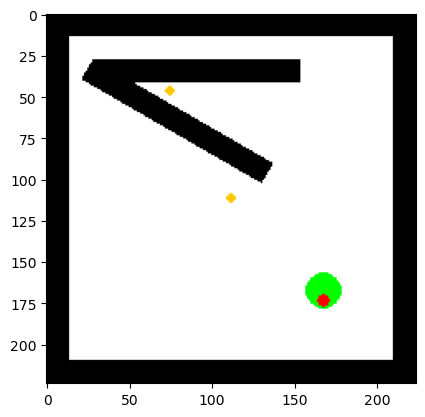

In [7]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [8]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [9]:
vocab_size = 10000
# tokenizer.save_model(".", "tokenizer/eng_sentences_tokenizer_vc10000")
tokenizer = ByteLevelBPETokenizer(
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-vocab.json",
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-merges.txt",
)   
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)   
tokenizer.enable_truncation(max_length=32)
tokenizer.enable_padding()

In [10]:
img_set = G.random_full_image_set(restrict_angles=True)

In [11]:
img_set.shape

(40, 224, 224, 3)

In [12]:
img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))

In [13]:
img_tensor.size()

torch.Size([40, 3, 224, 224])

In [14]:
img_tensor = img_tensor.to(device)

In [15]:
img_tensor.size()

torch.Size([40, 3, 224, 224])

In [16]:
img_tensor = img_tensor[:8]

In [17]:
img_tensor.size()

torch.Size([8, 3, 224, 224])

In [18]:
text_tensor = sdt[24:32].to(device)

In [19]:
text_tensor.device

device(type='cuda', index=1)

In [20]:
# ok, let's begin the forward function.
# let's do the version without img_weight first

In [21]:
b = text_tensor.size()[0]

In [22]:
b

8

In [23]:
src_attention_mask, src_key_padding_mask = model.get_masks(text_tensor, True)

In [24]:
text_encoding = model.get_text_encoding(text_tensor, src_attention_mask, src_key_padding_mask)

In [25]:
model.canvases.store(img_tensor)

In [26]:
context = []

In [27]:
real_img_context = model.img_enc(img_tensor)

In [28]:
real_img_context.size()

torch.Size([8, 256, 768])

In [29]:
context.append(real_img_context)

In [30]:
for i in range(model.canvases.num_canvases):
    context.append(model.img_enc(model.canvases[i]))

In [31]:
len(context)

4

In [32]:
for i in range(len(context)):
    context[i] += model.context_tagging[i]

In [33]:
# woops, forgot the memory tensor, but this is equivalent
context.append(torch.zeros(b, 128, 768, device=device, dtype=real_img_context.dtype) + model.context_tagging[4])

In [34]:
len(context)

5

In [35]:
tensor_context = torch.cat(context, dim=1)

In [36]:
tensor_context.size()

torch.Size([8, 1152, 768])

In [37]:
reaction = model.dopamine(real_img_context, tensor_context)

In [38]:
context.append(reaction + model.context_tagging[5])
tensor_context = torch.cat((tensor_context, context[-1]), dim=1)

In [39]:
model.context = tensor_context

In [40]:
text_probs = model.get_text_decoding(text_encoding, src_attention_mask, src_key_padding_mask, model.context, True)

In [41]:
model.memory.remember(model.mem_enc(text_encoding, model.context))

In [42]:
context.append(text_encoding + model.context_tagging[-1])

In [43]:
full_context = torch.cat((tensor_context, context[-1]), dim=1)

In [44]:
# now, the old forward, skipping img_weight:
img_recon = model.img_dec(real_img_context, full_context)

/home/atbolsh/anaconda3/envs/player/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36960426..1.2719826].


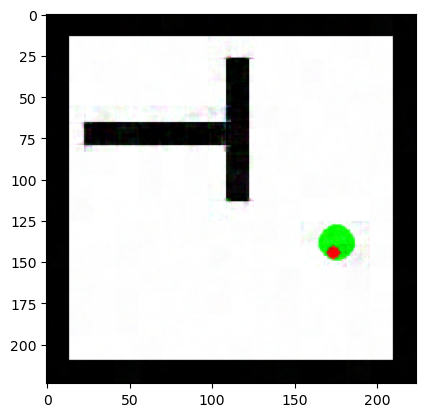

In [45]:
quick_display(img_recon[0])

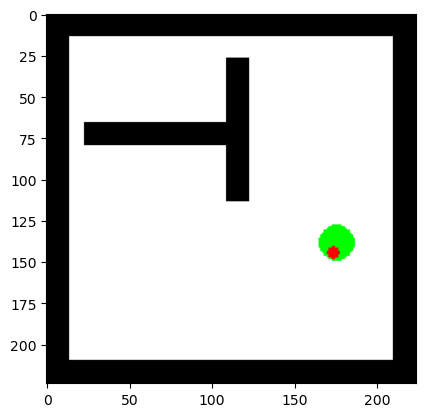

In [46]:
quick_display(img_tensor[0])

In [48]:
# X yeah, ok, I'm pretty convinced that the frankensteining failed
# X I'm pretty sure these are still the untrained weights in here.
############################
# UPDATE: all fixed!